In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

Посмотрим на наш датасет

In [43]:
df = pd.read_csv("./train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Мы видим пустые значения в колонках: Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score.

### Посмотрим на категориальные признаки

In [44]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [45]:
df["Years in current job"].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [46]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [47]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

### Численные признаки

In [48]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Посмотрим на распределение признаков

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

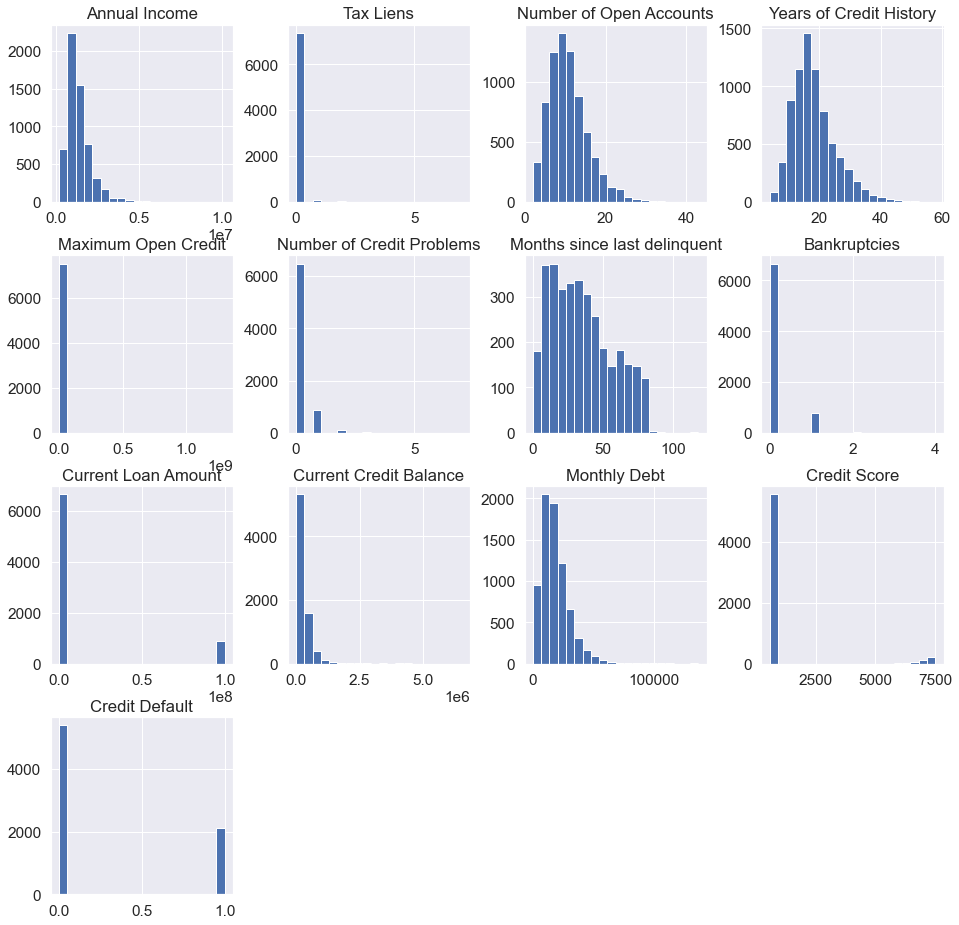

In [49]:
df.hist(figsize=(16,16), bins=20)

Из аномалий, которые видно на графиках:
1. Credit Score больше 1000 что явно похоже на ошибку в заполнении данных
2. Maximum open credit есть группа явно выбивающиеся по объему сумме
3. Нужно внимательнее посмотреть на признак Current Credit Balance, есть группа стоящая отдельно
4. Current Loan Amount - нужно проверить данные, есть группа остоящая далеко от основных данных

#### Credit Score
Судя по числам, тут ошибка ввода. Для приведения в норму, разделим данные этой выборки Credit Score на 10, чтобы привести рейтинг в норму.

#### Maximum Open Credit
Судя по всему это ошибка ввода, исправим это заменив значения больше 1 * 10^7 на медиану по этому признаку.

#### Current Credit Balance
Обработаем выборосы, откорректируем их заменив значения на медианные по признаку.

#### Current Loan Amount
Очень похоже на дефекты заполнения данных. Исправим как обычно на медианные значения.

#### Категориальные признаки сгруппируем, чтобы было меньше категорий.



In [50]:
class DataProcessing:
    """
    Класс для обработки данных в которых собраны все операции по подготовке данных для моделей обучения
    """
    
    def __init__(self):
        """Параметры класса"""
        #self.medians = None
        
    def fit(self, df):
        """
        Работа со статистиками набора
        """
        #self.medians = df.median()
        
    def transform(self, df):
        """
        Трансформация данных в соотвествии с критеяриями составленными при анализ данных
        """
        # заполняем пропуски в данных
        df = df.interpolate(method='spline', order=1, limit_direction='both')
        
        # заполняем пропуски в данных используя Interpolation
        #df['Annual Income'].mask(df['Annual Income'].isna(), df['Annual Income'].median(), inplace=True)
        df['Annual Income'].fillna(round(df['Annual Income'].median(),0), inplace=True)

        
        # заполняем пропуски в данных в признаке Months since last delinquent на медианное значение
        #df['Months since last delinquent'].mask(df['Months since last delinquent'].isna(), df['Months since last delinquent'].median(), inplace=True)
        df['Months since last delinquent'].fillna(int(df['Months since last delinquent'].median()), inplace=True)

        # заполняем пропуски в данных в признаке 'Bankruptcies' 0 
        #df['Bankruptcies'].mask(df['Bankruptcies'].isna(), 0, inplace=True)
        df['Bankruptcies'].fillna(0, inplace=True)

        # заполняем пропуски в Credit Score медианными значениями
        #df['Credit Score'].mask(df['Credit Score'].isna(), df['Credit Score'].median(), inplace=True)
        df['Credit Score'].fillna(int(df['Credit Score'].median()), inplace=True)

        # заполняем пропуски в данных в признаке 'Years in current job' 
        df['Years in current job'].mask(df['Years in current job'].isna(), '10+ years', inplace=True)
        
        # Отредактируем похожие на выборосы данные, заменим их медианой
        df['Credit Score'].mask(df['Credit Score'] > 1000, (df['Credit Score'] / 10), inplace=True)

        df['Maximum Open Credit'].mask(df['Maximum Open Credit'] > 10000000, df['Maximum Open Credit'].median(), inplace=True)

        df['Current Credit Balance'].mask(df['Current Credit Balance'] > 5.5e5, df['Current Credit Balance'].median(), inplace=True)

        df['Current Loan Amount'].mask(df['Current Loan Amount'] > 1e6, df['Current Loan Amount'].median(), inplace=True)
        
        # Объединим категориальные признаки, сделаем меньше групп
        df['New Year in current job'] = df['Years in current job'].map({'< 1 year':'< 10 years',\
                                                                        '1 year':'< 10 years',\
                                                                        '2 years':'< 10 years',\
                                                                        '3 years':'< 10 years',\
                                                                        '4 years':'< 10 years',\
                                                                        '4 years':'< 10 years',\
                                                                        '5 years':'< 10 years',\
                                                                        '6 years':'< 10 years',\
                                                                        '7 years':'< 10 years',\
                                                                        '8 years':'< 10 years',\
                                                                        '9 years':'< 10 years',\
                                                                        '10+ years':'10+ years'}).astype(object)
        df['New Purpose'] = df['Purpose'].map({'wedding':'other', 'take a trip':'other',\
                                               'vacation':'other', 'renewable energy':'other',\
                                               'educational expenses':'other', 'moving':'other',\
                                               'small business':'other', 'buy house':'other',\
                                               'major purchase':'other', 'other':'other',\
                                               'medical bills':'medical bills',\
                                               'buy a car':'buy a car', 'business loan':'business loan',\
                                               'home improvements':'home improvements',\
                                               'debt consolidation':'debt consolidation'}).astype(object)
        df['New Home Ownership'] = df['Home Ownership'].map({'Have Mortgage':'Home Mortgage',\
                                                             'Home Mortgage':'Home Mortgage', \
                                                             'Rent':'Rent', 'Own Home':'Own Home'}).astype(object)
        df.drop(labels=['Years in current job', 'Purpose', 'Home Ownership'], axis=1, inplace=True)
        df.rename(columns={'New Year in current job':'Years in current job', 'New Purpose':'Purpose',\
                           'New Home Ownership':'Home Ownership'}, inplace=True)
        
        group_score = [300, 580, 670, 740, 780, 850]
        
        df['Credit Score Groups'] = pd.cut(df['Credit Score'], group_score, labels=False)
        df['Credit Score Groups'].fillna(-1, inplace=True)
        
        # Генерируем dummies
        for cat_colname in df.select_dtypes(include='object').columns[0:]:
            df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)

        return df

In [51]:
DataProcessor = DataProcessing()
df = DataProcessor.transform(df)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Annual Income                    7500 non-null   float64
 1   Tax Liens                        7500 non-null   float64
 2   Number of Open Accounts          7500 non-null   float64
 3   Years of Credit History          7500 non-null   float64
 4   Maximum Open Credit              7500 non-null   float64
 5   Number of Credit Problems        7500 non-null   float64
 6   Months since last delinquent     7500 non-null   float64
 7   Bankruptcies                     7500 non-null   float64
 8   Term                             7500 non-null   object 
 9   Current Loan Amount              7500 non-null   float64
 10  Current Credit Balance           7500 non-null   float64
 11  Monthly Debt                     7500 non-null   float64
 12  Credit Score        

In [53]:
features = [col for col in list(df.columns) if col not in list(df.select_dtypes(include='object').columns)]
features.remove('Credit Default')
target_feature = ['Credit Default']
features, target_feature

(['Annual Income',
  'Tax Liens',
  'Number of Open Accounts',
  'Years of Credit History',
  'Maximum Open Credit',
  'Number of Credit Problems',
  'Months since last delinquent',
  'Bankruptcies',
  'Current Loan Amount',
  'Current Credit Balance',
  'Monthly Debt',
  'Credit Score',
  'Credit Score Groups',
  'Term_Long Term',
  'Term_Short Term',
  'Years in current job_10+ years',
  'Years in current job_< 10 years',
  'Purpose_business loan',
  'Purpose_buy a car',
  'Purpose_debt consolidation',
  'Purpose_home improvements',
  'Purpose_medical bills',
  'Purpose_other',
  'Home Ownership_Home Mortgage',
  'Home Ownership_Own Home',
  'Home Ownership_Rent'],
 ['Credit Default'])

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>],
       [<AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>],
       [<AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>,
        <AxesSubplot:title={'center':'Credit Default'}>,
        <AxesSubplot:title={'center':'Credit Score Groups'}>,
        <AxesSubplot:title={'center':'Term_Long Term'}>],
       [<AxesSubplot:title={'center':'Term_Short Term'}>,
        <AxesSubplot:title={'c

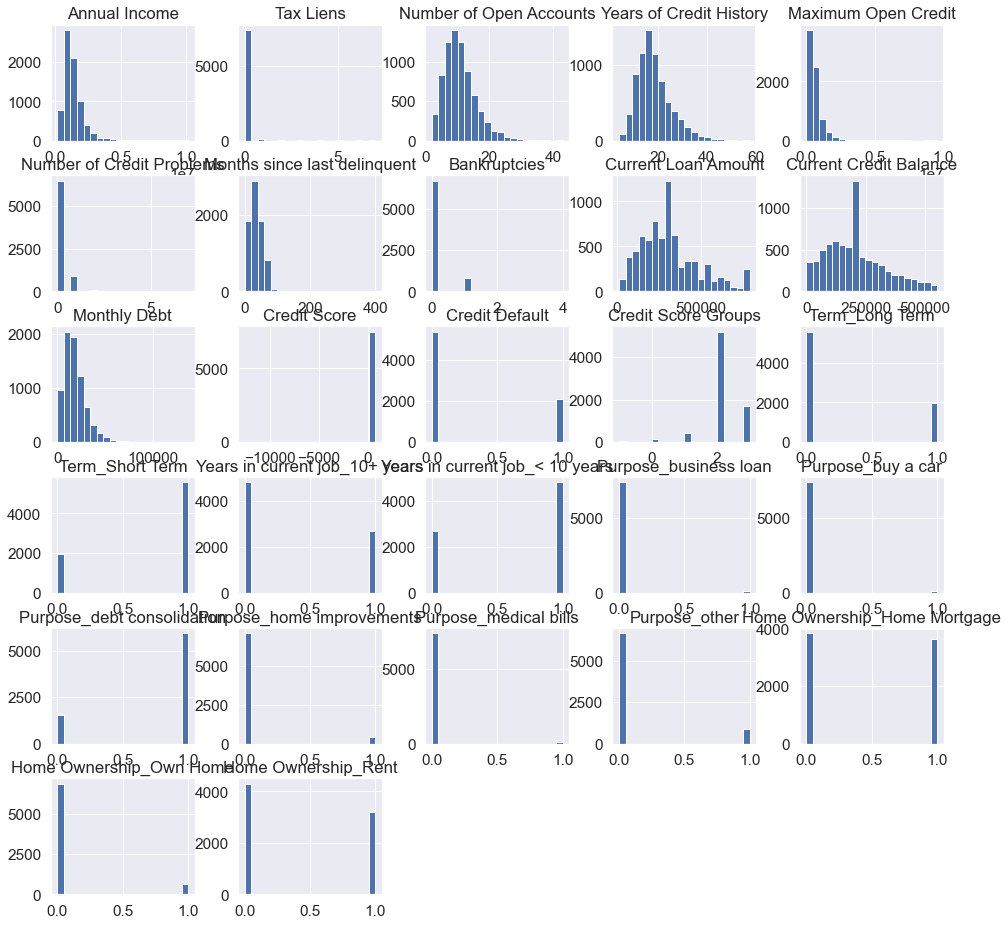

In [54]:
df.hist(figsize=(16,16), bins=20)

### Корреляция признаков

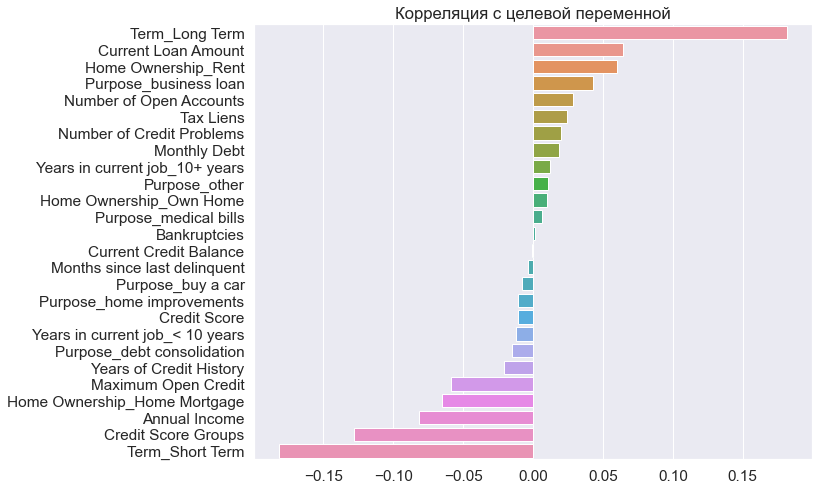

In [55]:
corr_with_target = df[features + target_feature].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

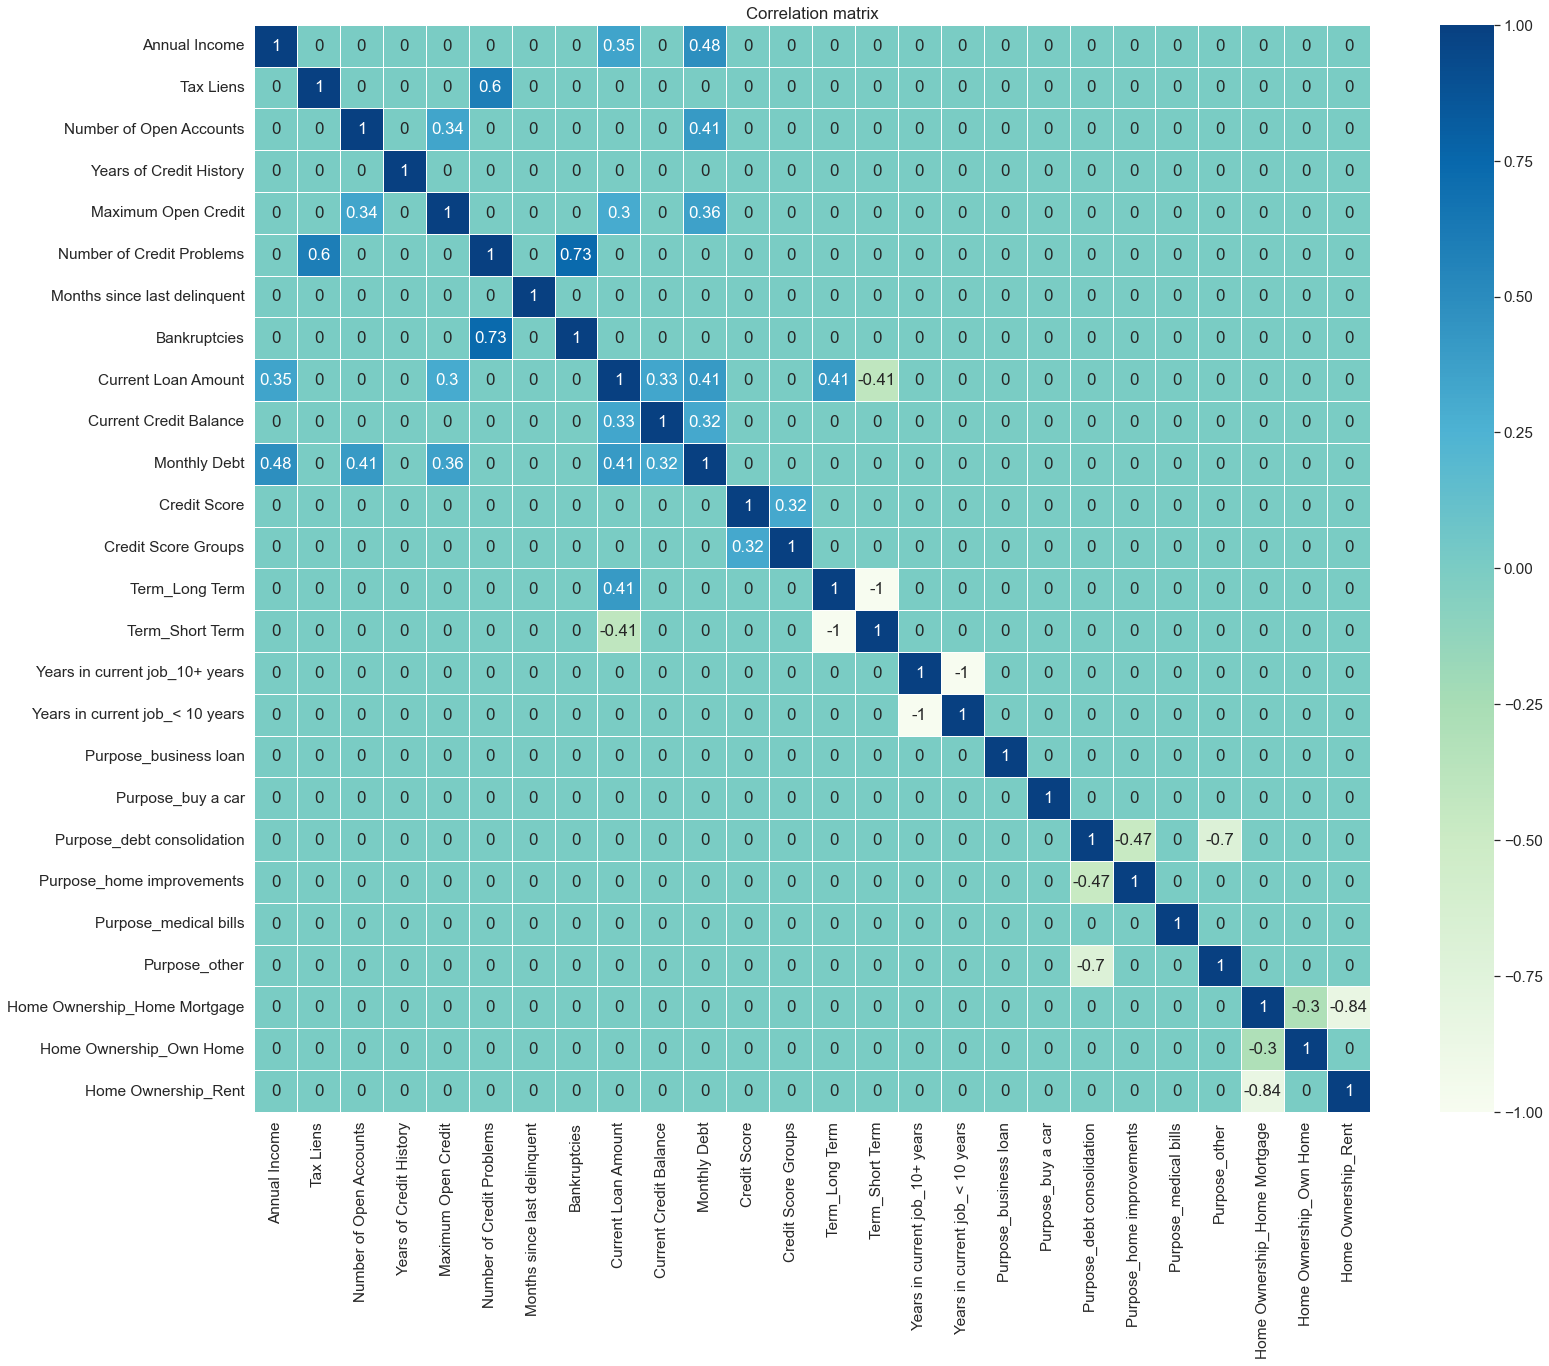

In [56]:
plt.figure(figsize=(25, 20))

sns.set(font_scale=1.4)

corr_matrix = df[features].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

По результатам анализа признаков можно сделать вывод о том, что ряд фичей мы можем откинуть, а именно: Bankruptcies, Months since last delinquent, Current Credit Balance, Purpose, Years of Credit History

In [57]:
features.remove('Bankruptcies')
features.remove('Credit Score')
features.remove('Months since last delinquent')
features.remove('Current Credit Balance')
features.remove('Purpose_home improvements')
features.remove('Purpose_medical bills')
features.remove('Purpose_other')
features.remove('Purpose_buy a car')
features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Monthly Debt',
 'Credit Score Groups',
 'Term_Long Term',
 'Term_Short Term',
 'Years in current job_10+ years',
 'Years in current job_< 10 years',
 'Purpose_business loan',
 'Purpose_debt consolidation',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent']

In [59]:
X = df[features]
y = df['Credit Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True,\
                                                    random_state=2, stratify=y)
X_train.shape, X_test.shape

((6000, 18), (1500, 18))

Добавим фукнцию для оценки модели

In [96]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

#### Посмотрим модель LGBMClassifier

In [97]:
model_lgbm = LGBMClassifier(metric='f1',
                            learning_rate=0.1, 
                            is_unbalance=True
                           )     
model_lgbm.fit(X_train, y_train)

pred_train = model_lgbm.predict(X_train)
pred_test  = model_lgbm.predict(X_test)


In [98]:
model_lgbm = LGBMClassifier(metric='f1_macro',
                            learning_rate=0.1, 
                            is_unbalance=True,
                            num_leaves=14,
                            max_depth=7,
                            n_estimators=40,
                            reg_lambda=0.2,
                            #categorical_feature=[7,8,9,10,11,12,13,14,15,16]
                           )

model_lgbm.fit(X_train, y_train)

pred_train = model_lgbm.predict(X_train)
pred_test  = model_lgbm.predict(X_test)

get_classification_report(y_train, pred_train, y_test, pred_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      4310
           1       0.47      0.77      0.58      1690

    accuracy                           0.69      6000
   macro avg       0.67      0.71      0.67      6000
weighted avg       0.76      0.69      0.70      6000

TEST

              precision    recall  f1-score   support

           0       0.83      0.63      0.72      1077
           1       0.41      0.67      0.51       423

    accuracy                           0.64      1500
   macro avg       0.62      0.65      0.61      1500
weighted avg       0.71      0.64      0.66      1500



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

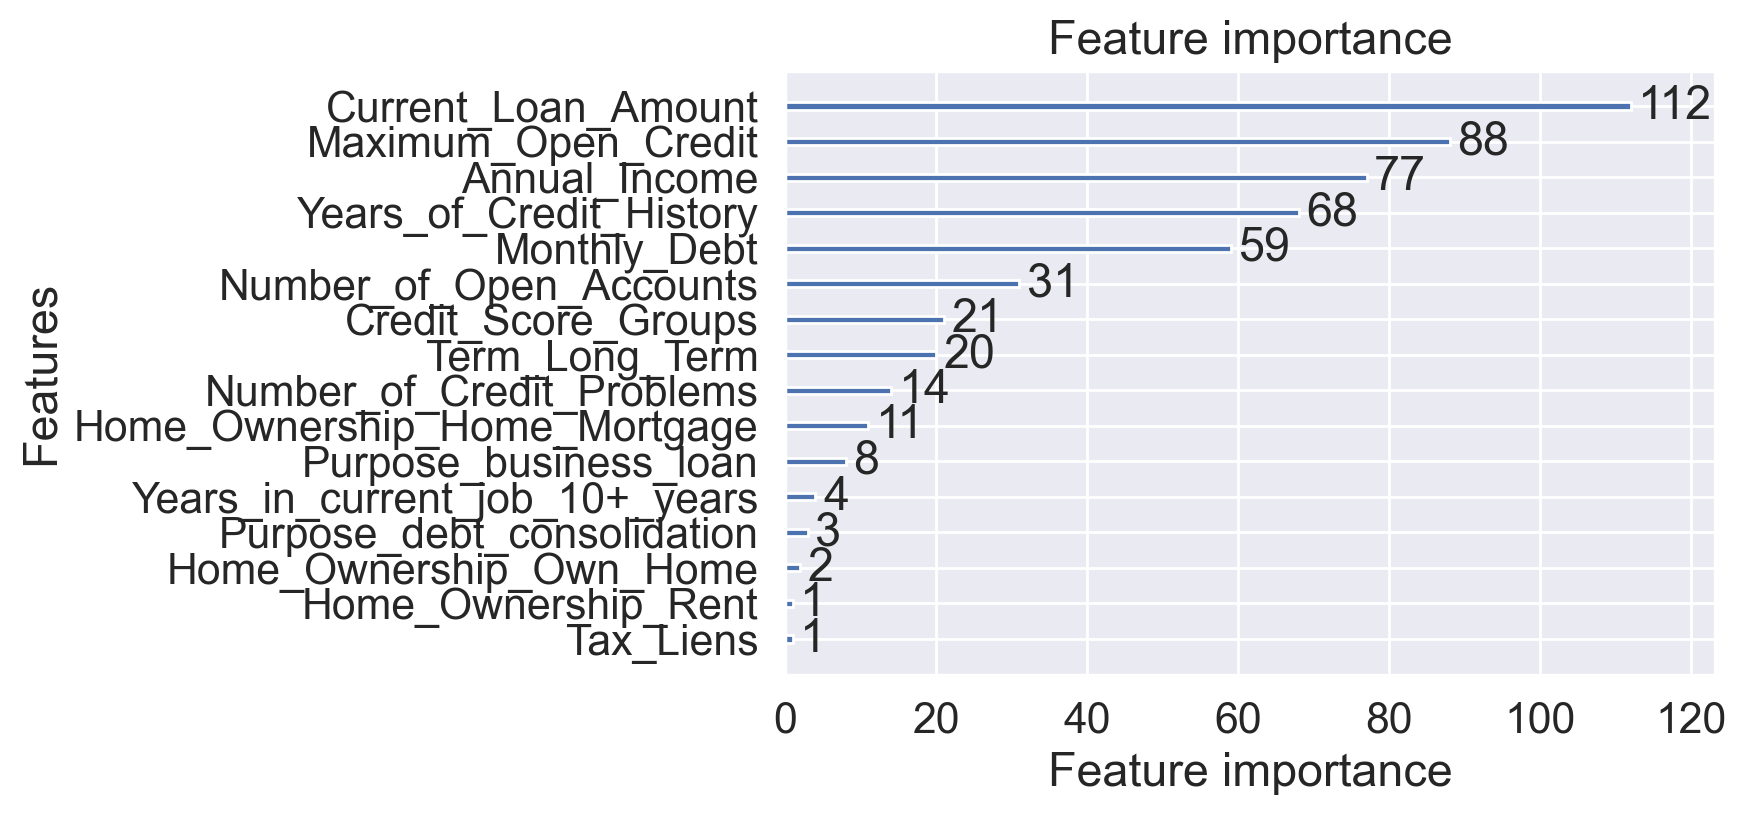

In [99]:
from lightgbm import plot_importance
plot_importance(model_lgbm, dpi=200)

In [100]:
df_test = pd.read_csv('./test.csv')
df_test = DataProcessor.transform(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Annual Income                    2500 non-null   float64
 1   Tax Liens                        2500 non-null   float64
 2   Number of Open Accounts          2500 non-null   float64
 3   Years of Credit History          2500 non-null   float64
 4   Maximum Open Credit              2500 non-null   float64
 5   Number of Credit Problems        2500 non-null   float64
 6   Months since last delinquent     2500 non-null   float64
 7   Bankruptcies                     2500 non-null   float64
 8   Term                             2500 non-null   object 
 9   Current Loan Amount              2500 non-null   float64
 10  Current Credit Balance           2500 non-null   float64
 11  Monthly Debt                     2500 non-null   float64
 12  Credit Score        

In [90]:
Test = df_test[features]
y_test_pred = model_lgbm.predict(Test)
submit = pd.read_csv("./sample_submission.csv")
submit['Credit Default'] = y_test_pred
submit['Credit Default'].value_counts()

1    1297
0    1203
Name: Credit Default, dtype: int64

In [91]:
submit.to_csv("./comit_submit.csv", index=False)